In [1]:
import numpy as np
import tonic 
from dv import AedatFile
import skimage.measure
from lava.proc.lif.process import LIF, LIFReset
from lava.proc.monitor.process import Monitor
from lava.proc.dense.process import Dense
from lava.proc.io.sink import RingBuffer
from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights, Convolution
from lava.lib.dnf.kernels.kernels import Kernel
from utils import plot_out
import input
from input.input_process import InputReader
from lava.proc.conv.process import Conv
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights, Convolution
from lava.lib.dnf.kernels.kernels import Kernel, SelectiveKernel, MultiPeakKernel
from lava.proc.monitor.process import Monitor
from numpy.lib import recfunctions as rfn

/home/amaya/lava-dnf/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
downsample_scale = (6,8)
original_size = (480,640)
downsampled_size = (original_size[0]//downsample_scale[0], original_size[1]//downsample_scale[1])
shape = (downsampled_size[0],downsampled_size[1])
flat_shape = (downsampled_size[0]*downsampled_size[1],)
time_steps = 250
num_neurons = downsampled_size[0]*downsampled_size[1]

# Selector -Leon Loic 

In [3]:
# Input data 
input_event = InputReader(shape=flat_shape, num_steps=time_steps)

# Initializing the SELECTOR
dnf_dense = Dense(weights=np.eye(num_neurons) * 50)
lif_select = LIF(shape=shape,du=1000, dv=2000, vth=200)
kernel = SelectiveKernel(amp_exc=15, width_exc=[10,10], global_inh=-8)

py_receiver_select = RingBuffer(shape=shape, buffer=time_steps)


# Initializing the MEMORY
dense_memory = Dense(weights=np.eye(num_neurons) * 5000)
lif_memory = LIF(shape=shape,du=409, dv=2047, vth=300)
kernel_memory = MultiPeakKernel(amp_exc=64,
                            	width_exc=[10,10],
                            	amp_inh=-48,
                            	width_inh=[20, 20])
py_receiver_memory = RingBuffer(shape=shape, buffer=time_steps)

# Initialising FEEDBACK
dense_feedback = Dense(weights=np.eye(num_neurons) * -500)
lif_feedback = LIF(shape=shape,du=40, dv=200, vth=30)

# Connecting the SELECT Network layers
input_event.flat_out.connect(dnf_dense.s_in)
dnf_dense.a_out.reshape(new_shape=shape).connect(lif_select.a_in)
connect(lif_select.s_out, lif_select.a_in, [Convolution(kernel)])
lif_select.s_out.connect(py_receiver_select.a_in)

# Connecting the MEMORY Network layes
lif_select.s_out.flatten().connect(dense_memory.s_in)
dense_memory.a_out.reshape(new_shape=shape).connect(lif_memory.a_in)
#lif_select.s_out.connect(lif_memory.a_in)
#dense_memory.s_in.reshape(new_shape=shape).connect(lif_select.s_out)
#dense_memory.a_out.reshape(new_shape=shape).connect(lif_memory.a_in)
connect(lif_memory.s_out, lif_memory.a_in, [Convolution(kernel_memory)])

# feedback loop to LIF layer
#lif_memory.s_out.connect(lif_memory.a_in)

lif_memory.s_out.connect(py_receiver_memory.a_in)

# Feedback to selector
lif_memory.s_out.connect(lif_feedback.a_in)
lif_feedback.s_out.flatten().connect(dense_feedback.s_in)
dense_feedback.a_out.reshape(new_shape=shape).connect(lif_select.a_in)

# Classifier

In [4]:
print(f"LIF out: {lif_memory.s_out.shape}")
print(f"LIF in: {lif_memory.a_in.shape}")

LIF out: (80, 80)
LIF in: (80, 80)


# Memory - Fabi Yannik

In [5]:
# initialise input

run_cfg = Loihi2SimCfg(select_tag="fixed_pt")
condition = RunSteps(num_steps=time_steps)
input_event.run(condition=condition, run_cfg=run_cfg)

dnf_select = py_receiver_select.data.get().transpose()
dnf_memory = py_receiver_memory.data.get().transpose()

input_event.stop()

The total time of the recording is 5669730 us
(566, 80, 80)
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
I

# State machine 

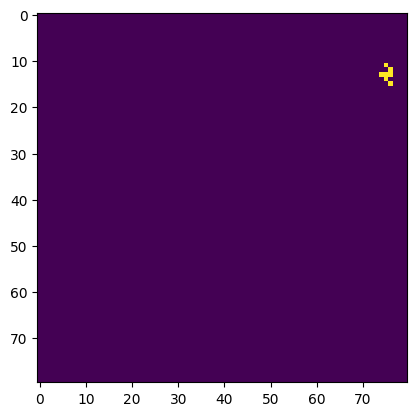

In [6]:
from IPython.display import HTML

ani = plot_out(dnf_select, "dnf_sockets")
HTML(ani.to_jshtml())

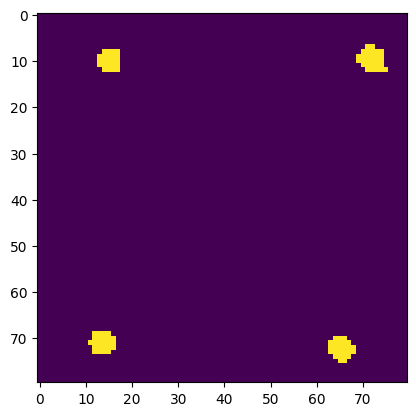

In [7]:

ani_memory = plot_out(dnf_memory, "dnf_sockets")
HTML(ani_memory.to_jshtml())

In [8]:
dnf_memory.max()
#dnf_select.mean()

1.0